In [1]:
from emnist import extract_training_samples
from emnist import extract_test_samples

In [2]:
X, y = extract_training_samples('letters')
X_test, y_test = extract_test_samples('letters')
X_train = X[:104800]/255.
X_valid = X[104800:]/255
X_test = X_test/255.
y_train = y[:104800]
y_valid = y[104800:]
# jedes Pixel in allen Bildern einen Wert zwischen 0 und 1 hat
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)
# 124800 Bilder fürs Trainieren
# 20800 Bilder fürs Testen

(104800, 28, 28)
(20000, 28, 28)
(20800, 28, 28)


In [3]:
# Bilder von Training- und Test Datensatz zeigen 
import matplotlib.pyplot as plt

img_index_train = 8888 # das 8888. Image ausnehmen
img_train = X_train[img_index_train]
print("Training - Der Buchstabe Label: " + str(chr(y_train[img_index_train]+96)))

plt.imshow(img_train.reshape((28,28)), cmap='gray')

Training - Der Buchstabe Label: y


Test - Das Bild zeigt: c


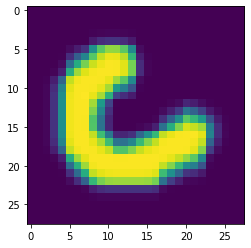

In [4]:
img_index_test = 1888
img_test = X_test[img_index_test]
print("Test - Das Bild zeigt: " + str(chr(y_test[img_index_test]+96)))
plt.imshow(img_test.reshape((28,28)))

In [5]:
import numpy as np
import random

n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]
image_shape = X_train[0].shape
n_classes = len(np.unique(y_train))
random.seed(4242)

print("Number of Training Images   =", n_train)
print("Number of validation Images =", n_train)
print("Number of Test Images       =", n_test)
print("Image Format                =", image_shape)
print("Number of Classes           =", n_classes)

Number of Training Images   = 104800
Number of validation Images = 104800
Number of Test Images       = 20800
Image Format                = (28, 28)
Number of Classes           = 26


In [6]:
from keras.utils import np_utils

y_train_cat = np_utils.to_categorical(y_train-1, 26)
y_valid_cat = np_utils.to_categorical(y_valid-1, 26)
y_test_cat = np_utils.to_categorical(y_test-1, 26)

Using TensorFlow backend.


In [7]:
X_train = X_train.astype('float32')
X_valid = X_valid.astype('float32')
X_test = X_test.astype('float32')
print("Shape before = ", X_train.shape)
X_train_reshaped = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_valid_reshaped = X_valid.reshape(X_valid.shape[0], 28, 28, 1)
X_test_reshaped = X_test.reshape(X_test.shape[0], 28, 28, 1)
print("Shape after  = ", X_train_reshaped.shape)

Shape before =  (104800, 28, 28)
Shape after  =  (104800, 28, 28, 1)


In [8]:
BATCH_SIZE = 100
EPOCHS     = 3

In [9]:
from keras.preprocessing.image import ImageDataGenerator
# Preparing data generators for data augmentation
train_datagen = ImageDataGenerator(shear_range=2, 
                                   zoom_range=0.2, 
                                   rotation_range=5, 
                                   width_shift_range=4, 
                                   height_shift_range=4, 
                                   featurewise_center=False, 
                                   samplewise_center=False, 
                                   featurewise_std_normalization=False, 
                                   samplewise_std_normalization=False)
# fit parameters from data
train_datagen.fit(X_train_reshaped)

validation_datagen = ImageDataGenerator(featurewise_center=False, 
                                        samplewise_center=False, 
                                        featurewise_std_normalization=False, 
                                        samplewise_std_normalization=False)

train_generator = train_datagen.flow(X_train_reshaped, 
                                     y=y_train_cat, 
                                     batch_size=BATCH_SIZE)
validation_generator = validation_datagen.flow(X_valid_reshaped,
                                               y=y_valid_cat,
                                               batch_size=BATCH_SIZE)

In [10]:
import keras
from keras import models, layers

dp = 0.15

class VGGNet(models.Sequential):
    def __init__(self, input_shape, nb_classes):
        super().__init__()
        self.add(Conv2D(32, (3, 3), padding='same',input_shape=input_shape))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Conv2D(32, (3, 3), padding='same'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(Dropout(dp))
        self.add(Conv2D(64, (3, 3), padding='same'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Conv2D(64, (3, 3), padding='same'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(Dropout(dp))
        self.add(Conv2D(128, (3, 3), padding='same'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Conv2D(128, (3, 3), padding='same'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
        self.add(Dropout(dp))
        #-------------------------------Fully Connected Layer----------------------------------------
        self.add(Flatten(name='flatten'))
        self.add(Dense(128, name='fc1'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dropout(dp))
        self.add(Dense(128, name='fc2'))
        self.add(BatchNormalization())
        self.add(Activation('relu'))
        self.add(Dropout(dp))
        self.add(Dense(26, name='fc3', activation ="softmax"))

In [11]:
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization, regularizers, ELU
from keras.layers import Conv2D, MaxPooling2D, LeakyReLU, AveragePooling2D

input_shape = X_train_reshaped[0].shape
model = VGGNet(input_shape, n_classes)
model.summary()

W0630 01:48:34.606642 4499103168 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0630 01:48:34.618435 4499103168 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0630 01:48:34.620506 4499103168 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0630 01:48:34.642463 4499103168 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 28, 28, 32)        128       
_________________________________________________________________
activation_2 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [12]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

W0630 01:48:35.294076 4499103168 deprecation_wrapper.py:119] From /Applications/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



In [13]:
# Training the model
model.fit_generator(train_generator, 
                    steps_per_epoch=n_train/BATCH_SIZE, 
                    epochs=EPOCHS,
                    validation_steps=n_valid/BATCH_SIZE,
                    validation_data=validation_generator, 
                    verbose=1)

W0630 01:48:35.413274 4499103168 deprecation.py:323] From /Applications/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/3
1048/1048 [==============================] - 330s 315ms/step - loss: 0.6745 - acc: 0.7973 - val_loss: 0.2657 - val_acc: 0.9077
Epoch 2/3
1048/1048 [==============================] - 327s 312ms/step - loss: 0.2909 - acc: 0.9035 - val_loss: 0.2248 - val_acc: 0.9243
Epoch 3/3
1048/1048 [==============================] - 326s 311ms/step - loss: 0.2501 - acc: 0.9158 - val_loss: 0.1724 - val_acc: 0.9386


In [14]:
score = model.evaluate(X_test_reshaped, y_test_cat)

print('Test Ergebniss')
print('Test loss:    ', score[0])
print('Test accuracy:', score[1])

20800/20800 [==============================] - 12s 573us/step
Test Ergebniss
Test loss:     0.17611515359168362
Test accuracy: 0.9371153846153846


In [15]:
resultingClasses = np.argmax(model.predict(X_test_reshaped), axis=1)
incorrects = np.nonzero(resultingClasses != y_test-1)
print("Total number of misclassifications: ", len(incorrects[0]))

Total number of misclassifications:  1308


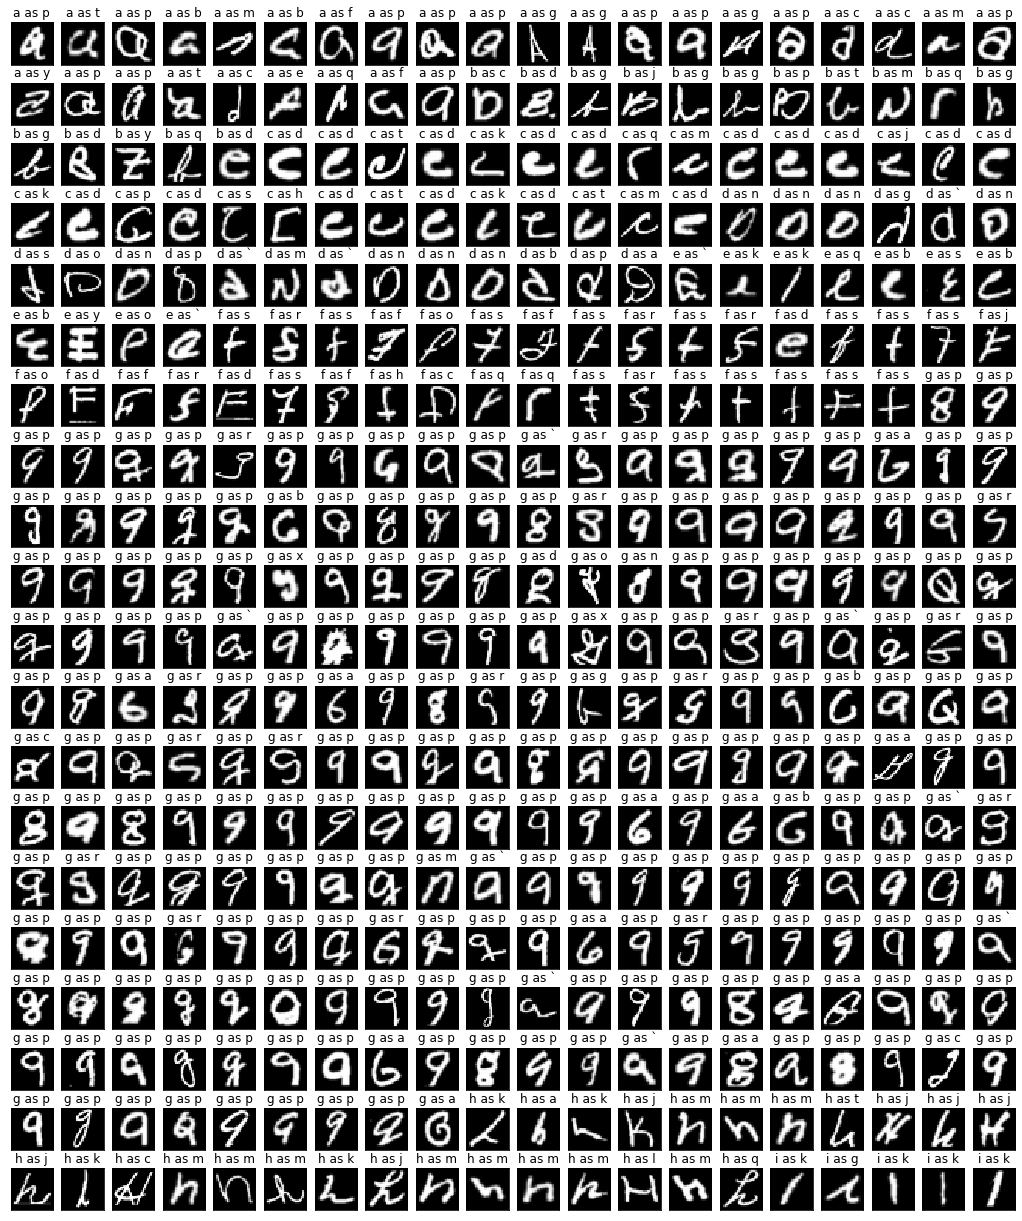

In [16]:
plt.figure(figsize=(18,22))
index = 0
for imageNumber in incorrects[0]:
    #print(imageNumber)
    plt.subplot(20,20,index+1)
    plt.imshow(X_test[imageNumber], cmap='gray')
    plt.title("{} as {}".format(chr(y_test[imageNumber]+96), chr(resultingClasses[imageNumber]+96)))
    plt.xticks([])
    plt.yticks([])
    index = index + 1
    if index >= 400:
        break